### Setup

In [1]:
!pip install torch

### Preparing training data
The training data is composed of pairs (x<sub>1</sub>, x<sub>2</sub>) so that x<sub>2</sub> consists of the value of the sine of x<sub>1</sub> for x<sub>2</sub> in the interval from 0 to 2π \
(0 to 2π so that the sin wave is complete)

In [2]:
import math
import torch
from torch import nn

torch.manual_seed(111)
train_data_length = 1024

train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)
train_data[:, 1] = torch.sin(train_data[:, 0])

train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

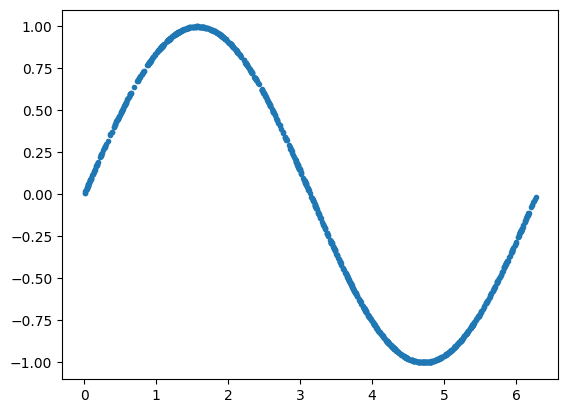

In [3]:
import matplotlib.pyplot as plt

plt.plot(train_data[:, 0], train_data[:, 1], ".")

### Preparing training and testing samples for the models

In [4]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True) # Training Data
latent_space_samples = torch.randn(train_data_length, 2) # Testing Data

### Implementing the Discriminator

In [5]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
      nn.Linear(2, 256),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )

  def forward(self, x):
    output = self.model(x)
    return output

discriminator = Discriminator()

### Implementing the Generator

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

generator = Generator()

### Train the model

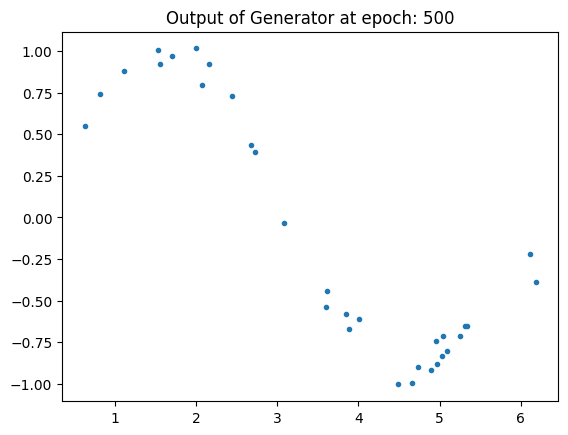

In [7]:
from time import sleep
from IPython.display import clear_output

lr = 0.0001
num_epochs = 500
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

loss_values = ""
for epoch in range(1, num_epochs + 1):
  for n, (real_samples, _) in enumerate(train_loader):
    # Data for training the discriminator
    real_samples_labels = torch.ones((batch_size, 1))
    latent_space_samples = torch.randn((batch_size, 2))
    generated_samples = generator(latent_space_samples)
    generated_samples_labels = torch.zeros((batch_size, 1))

    all_samples = torch.cat((real_samples, generated_samples))
    all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

    # Training the discriminator
    discriminator.zero_grad()
    output_discriminator = discriminator(all_samples)
    
    # Discriminator loss
    loss_discriminator = loss_function(output_discriminator, all_samples_labels)
    loss_discriminator.backward()
    optimizer_discriminator.step()

    # Data for training the generator
    latent_space_samples = torch.randn((batch_size, 2))

    # Training the generator
    generator.zero_grad()
    generated_samples = generator(latent_space_samples)
    output_discriminator_generated = discriminator(generated_samples)

    # Generator loss
    loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
    loss_generator.backward()
    optimizer_generator.step()

    # Show loss and visualize the outputs
    if (epoch % 5 == 0) and (n == batch_size - 1):
      clear_output(wait=True)
      loss_values += f"Epoch: {epoch} Loss in D.: {loss_discriminator}\n" + f"Epoch: {epoch} Loss in G.: {loss_generator}\n" + "--------------------\n"
      generated_samples = generated_samples.detach() # converts into a normal tensor (which can be converted to numpy)
      plt.title(f"Output of Generator at epoch: {epoch}")
      plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
      plt.show()
      sleep(0.1)

### Testing the model

Epoch: 10 Loss in D.: 0.28041309118270874
Epoch: 10 Loss in G.: 2.0232841968536377
--------------------
Epoch: 20 Loss in D.: 0.4833296537399292
Epoch: 20 Loss in G.: 1.3987178802490234
--------------------
Epoch: 30 Loss in D.: 0.40394213795661926
Epoch: 30 Loss in G.: 1.1115317344665527
--------------------
Epoch: 40 Loss in D.: 0.3382267951965332
Epoch: 40 Loss in G.: 1.1963694095611572
--------------------
Epoch: 50 Loss in D.: 0.5464051961898804
Epoch: 50 Loss in G.: 1.1169973611831665
--------------------
Epoch: 60 Loss in D.: 0.5526493191719055
Epoch: 60 Loss in G.: 1.0221797227859497
--------------------
Epoch: 70 Loss in D.: 0.5971188545227051
Epoch: 70 Loss in G.: 0.8288434743881226
--------------------
Epoch: 80 Loss in D.: 0.6406172513961792
Epoch: 80 Loss in G.: 0.7929569482803345
--------------------
Epoch: 90 Loss in D.: 0.6573036909103394
Epoch: 90 Loss in G.: 0.7523266077041626
--------------------
Epoch: 100 Loss in D.: 0.6357570290565491
Epoch: 100 Loss in G.: 0.8103

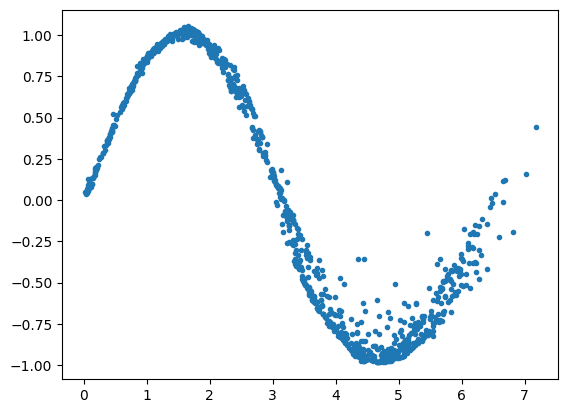

In [7]:
# Loss at various epochs
print(loss_values)

latent_space_samples = torch.randn(train_data_length, 2)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")

### How GAN learns:
<img src="./GAN training 500 epochs.gif" alt="GAN training 500 epochs">